Databases actuales: df_chess

In [1]:
import sys
sys.path.append("../functions")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from functions import load_csv
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

DATA_DIR = Path("../data/raw")

PD_KW = dict(dtype_backend="pyarrow")

df_chess = load_csv(DATA_DIR / "chessData.csv")

In [13]:
print(df_chess.shape)
print(df_chess.select_dtypes(include=[np.number]).columns)

(12958035, 2)
Index([], dtype='object')


In [ ]:
def detect_chess_outliers(df):
    """Detección de outliers ajedrez"""
    
    print("Columnas:", df.columns.tolist())
    print("Primeras filas:")
    print(df.head())

    df_clean = df.copy()
    df_clean.columns = ['fen', 'evaluation']

    # M-X o #-X (Mate para el negro) -> -20000
    df_clean['evaluation'] = df_clean['evaluation'].astype(str).str.replace(r'[\#]?M[-|–]\d+', '-20000', regex=True)
    
    # M+X o #M+X (Mate para el blanco) -> +20000
    df_clean['evaluation'] = df_clean['evaluation'].astype(str).str.replace(r'[\#]?M\+?\d+', '20000', regex=True)
    
    df_clean['evaluation'] = pd.to_numeric(df_clean['evaluation'], errors='coerce')

    print("Filas originales:", df.shape[0])
    print("Filas después de limpieza:", df_clean.shape[0])
            
    # Eliminar filas con evaluaciones no válidas
    df_clean = df_clean.dropna(subset=['evaluation'])
    print("Filas eliminadas:", df.shape[0] - df_clean.shape[0])

    print(f"Datos limpios: {df_clean.shape}")
    print(f"Rango de evaluaciones: {df_clean['evaluation'].min():.2f} a {df_clean['evaluation'].max():.2f}")
        
    # Ahora aplicar detección de outliers solo a la evaluación
    eval_series = df_clean['evaluation']
        
    # Método 1: IQR para evaluaciones
    Q1 = eval_series.quantile(0.25)
    Q3 = eval_series.quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = ((eval_series < Q1 - 1.5 * IQR) | 
                       (eval_series > Q3 + 1.5 * IQR))
        
    # Método 2: Z-Score
    z_scores = np.abs(stats.zscore(eval_series))
    outliers_zscore = (z_scores > 3)
        
    # Método 3: Evaluaciones extremas (>15 o <-15)
    outliers_extreme = (eval_series.abs() > 10)
        
    # Visualización específica para ajedrez
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
        
    # Plot 1: Distribución de evaluaciones
    ax1 = axes[0, 0]
    eval_series.hist(bins=50, ax=ax1, alpha=0.7)
    ax1.axvline(Q1 - 1.5 * IQR, color='red', linestyle='--', label='IQR límites')
    ax1.axvline(Q3 + 1.5 * IQR, color='red', linestyle='--')
    ax1.set_title('Distribución de Evaluaciones')
    ax1.set_xlabel('Evaluación (centipawns)')
    ax1.set_ylabel('Frecuencia')
    ax1.legend()
        
    # Plot 2: Boxplot de evaluaciones
    ax2 = axes[0, 1]

    # 1. Crear una serie TEMPORALmente filtrada (puedes mantener el filtro de +/- 5)
    eval_series_filtered = eval_series[(eval_series >= -10) & (eval_series <= 10)]
    count_filtered = len(eval_series_filtered)
    print(f"Boxplot usando {count_filtered} evaluaciones filtradas entre -10 y 10 centipawns.")

    # 2. Usar la serie filtrada para el boxplot.
    
    ax2 = axes[0,1]
    bp = ax2.boxplot(eval_series_filtered, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    q1, q3 = eval_series_filtered.quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = eval_series_filtered[(eval_series_filtered < q1 - 1.5*iqr) | (eval_series_filtered > q3 + 1.5*iqr)]
    ax2.set_title(f'Boxplot (outliers: {len(outliers)})')
    # Plot 3: Scatter de outliers
    ax3 = axes[1, 0]
    normal_mask = ~(outliers_iqr | outliers_zscore | outliers_extreme)
    ax3.scatter(range(len(eval_series[normal_mask])), 
                   eval_series[normal_mask].sort_values(), 
                   alpha=0.6, s=1, label='Normal')
    ax3.scatter(range(len(eval_series[outliers_iqr])), 
                   eval_series[outliers_iqr].sort_values(), 
                   color='red', s=3, label='Outliers IQR')
    ax3.set_title('Detección de Outliers')
    ax3.set_xlabel('Índice ordenado')
    ax3.set_ylabel('Evaluación')
    ax3.legend()
        
    # Plot 4: Resumen
    ax4 = axes[1, 1]
    ax4.axis('off')
        
    summary_text = f"""
        Análisis de Outliers en Datos de Ajedrez:
        
        • Total de posiciones: {len(df_clean):,}
        • Rango de evaluaciones: {eval_series.min():.1f} a {eval_series.max():.1f}
        • Rango de evaluaciones: Quantiles 25%: {Q1:.1f}, 75%: {Q3:.1f}, IQR: {IQR:.1f}

        
        Outliers detectados:
        • Por IQR: {outliers_iqr.sum():,} ({outliers_iqr.sum()/len(df_clean)*100:.1f}%)
        • Por Z-Score: {outliers_zscore.sum():,} ({outliers_zscore.sum()/len(df_clean)*100:.1f}%)
        • Evaluaciones extremas (>15): {outliers_extreme.sum():,} ({outliers_extreme.sum()/len(df_clean)*100:.1f}%)
        
        Estadísticas:
        • Media: {eval_series.mean():.2f}
        • Mediana: {eval_series.median():.2f}
        • Desv. estándar: {eval_series.std():.2f}
        
        Posiciones más extremas:
        • Más favorable: {eval_series.max():.1f}
        • Más desfavorable: {eval_series.min():.1f}
        """
        
    ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes,
                fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue'))
    
    # Plot 5: KDE (Kernel Density Estimate) para evaluar la concentración
    ax5 = axes[2, 0] 
    
    # *** AJUSTE DEL ANCHO DE BANDA: Usamos un método de cálculo específico ***
    sns.kdeplot(eval_series, ax=ax5, fill=True, bw_method='scott') 
    
    ax5.set_xlim(-5000, 5000) # Mantenemos el zoom en X para ver la región central
    ax5.set_title('Densidad de Evaluaciones (KDE Ajustado)')
    ax5.set_xlabel('Evaluación (centipawns)')
    ax5.set_ylabel('Densidad')

    #Outliers por isolation forest
    ax6 = axes[2, 1]
    scaler = StandardScaler()
    eval_scaled = scaler.fit_transform(eval_series.values.reshape(-1, 1))
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    outliers_if = iso_forest.fit_predict(eval_scaled)
    ax6.scatter(range(len(eval_series[outliers_if == 1])), 
                   eval_series[outliers_if == 1].sort_values(), 
                   alpha=0.6, s=1, label='Normal')
    ax6.scatter(range(len(eval_series[outliers_if == -1])),
                     eval_series[outliers_if == -1].sort_values(), 
                     color='orange', s=3, label='Outliers Isolation Forest')
    ax6.set_title('Outliers por Isolation Forest')
    ax6.set_xlabel('Índice ordenado')
    ax6.set_ylabel('Evaluación')
    ax6.legend()
        
    plt.suptitle('Análisis de Outliers - Datos de Ajedrez', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n Ejemplos de outliers extremos:")
    extreme_outliers = df_clean[outliers_extreme].nlargest(5, 'evaluation')
    for idx, row in extreme_outliers.iterrows():
        print(f"FEN: {row['fen']}")
        print(f"Evaluación: {row['evaluation']}")
        print("-" * 50)
        
    return outliers_iqr, outliers_zscore, outliers_extreme

Columnas: ['FEN', 'Evaluation']
Primeras filas:
                                                 FEN Evaluation
0  rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...        -10
1  rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...        +56
2  rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...         -9
3  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...        +52
4  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...        -26
Filas originales: 12958035
Filas después de limpieza: 12958035
Filas eliminadas: 190154
Datos limpios: (12767881, 2)
Rango de evaluaciones: -15312.00 a 15319.00
Boxplot usando 1585960 evaluaciones filtradas entre -10 y 10 centipawns.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26616\470089369.py:155: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\ASUS\Desktop\stocksalmon\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


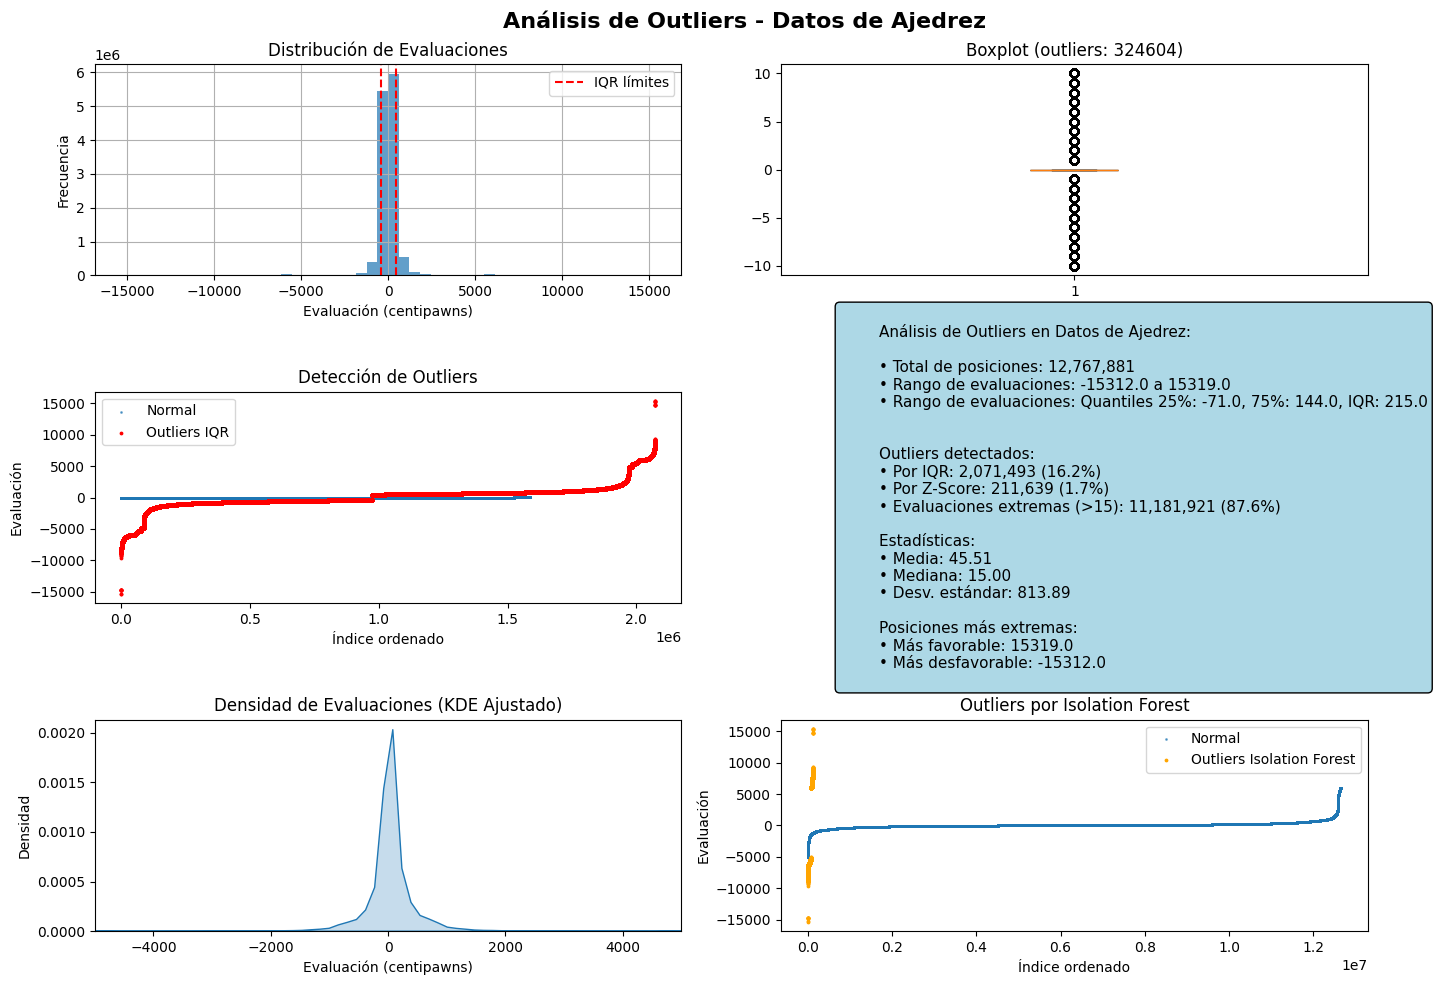


 Ejemplos de outliers extremos:
FEN: 6q1/6P1/2Q3K1/7P/1k6/8/8/8 b - - 4 77
Evaluación: 15319.0
--------------------------------------------------
FEN: 8/5PK1/4q3/6Q1/8/8/8/1k6 b - - 12 86
Evaluación: 15313.0
--------------------------------------------------
FEN: 6K1/3q1P2/8/6Q1/8/8/8/1k6 b - - 10 85
Evaluación: 15295.0
--------------------------------------------------
FEN: 8/4K1P1/1k6/8/2q5/5Q2/8/8 w - - 15 104
Evaluación: 15291.0
--------------------------------------------------
FEN: 8/k3K1P1/8/4Q3/8/5q2/8/8 b - - 2 97
Evaluación: 15275.0
--------------------------------------------------


(0           False
 1           False
 2           False
 3           False
 4           False
             ...  
 12958030    False
 12958031    False
 12958032    False
 12958033    False
 12958034    False
 Name: evaluation, Length: 12767881, dtype: bool,
 array([False, False, False, ..., False, False, False], shape=(12767881,)),
 0           False
 1            True
 2           False
 3            True
 4            True
             ...  
 12958030    False
 12958031     True
 12958032    False
 12958033     True
 12958034     True
 Name: evaluation, Length: 12767881, dtype: bool)

In [66]:
detect_chess_outliers(df_chess)